In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2             
%matplotlib inline     

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 54.8MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
!pip install soynlp

     |████████████████████████████████| 419kB 12.6MB/s 


In [4]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 33), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [5]:
ls

drive/  Mecab-ko-for-Google-Colab/  sample_data/


In [6]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [7]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 51.5MB/s 
     |████████████████████████████████| 92kB 12.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-12-08 13:00:56--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downlo

In [61]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Mecab
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from konlpy.tag import Okt
import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.font_manager as fm
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import warnings
warnings.filterwarnings(action='ignore')

In [62]:
train = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_train.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv", index_col=0)
sample_submission = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv")

In [63]:
trn = train['content']
tst = test['content']
print(train['content'][0])

[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도


In [64]:
tf = CountVectorizer()

In [74]:
X_train = tf.fit_transform(trn)
X_test = tf.transform(tst)
# X_test = tf.fit_transform(tst)

print(X_train.shape)
print(X_test.shape)

(118745, 158244)
(142565, 158244)


In [75]:
X_train[0, :50].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

##**로지스틱 회귀 모델 학습**

In [69]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [71]:
Y_train = train['info']
Y_test = sample_submission['info']

print(Y_train.shape)
print(Y_test.shape)

(118745,)
(142565,)


In [76]:
p = np.zeros((X_train.shape[0], 2))
p_tst = np.zeros((X_test.shape[0], 2))
for i_cv, (i_trn, i_val) in enumerate(cv.split(X_train, Y_train), 1):
    clf = LogisticRegression()
    clf.fit(X_train[i_trn], Y_train[i_trn])
    p[i_val, :] = clf.predict_proba(X_train[i_val])
    p_tst += clf.predict_proba(X_test) / 2

In [78]:
print(f'Accuracy (CV): {accuracy_score(Y_train, np.argmax(p, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(Y_train), p):8.4f}')

Accuracy (CV):  97.8408%
Log Loss (CV):   0.0635


In [79]:
print(p_tst[:20])

[[1.98240977e+00 5.17590227e-01]
 [2.49692368e+00 3.07632461e-03]
 [2.48319329e+00 1.68067070e-02]
 [2.49657884e+00 3.42115638e-03]
 [2.49726014e+00 2.73986500e-03]
 [1.77790442e+00 7.22095578e-01]
 [2.49359690e+00 6.40309846e-03]
 [2.23868313e+00 2.61316873e-01]
 [2.47950450e+00 2.04954957e-02]
 [2.49992383e+00 7.61725025e-05]
 [2.49286368e+00 7.13631969e-03]
 [2.28947073e+00 2.10529273e-01]
 [2.47400617e+00 2.59938346e-02]
 [2.49231457e+00 7.68543356e-03]
 [2.49904223e+00 9.57773184e-04]
 [2.48423926e+00 1.57607355e-02]
 [2.45873464e+00 4.12653616e-02]
 [2.44110698e+00 5.88930208e-02]
 [2.17485214e+00 3.25147864e-01]
 [2.49998582e+00 1.41792481e-05]]


In [81]:
# sample_submission['info'] = np.where(pred_test> 0.5, 1,0)
sample_submission['info'] = np.where(p_tst[:, 0] > 0.5, 0, 1)

sample_submission

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [82]:
sample_submission.to_csv('/content/drive/My Drive/AI 진짜 뉴스/result/TF-IDF_2_201208.csv', index=False)
sample_submission

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


##**TF-IDF test**

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer 

text_data = [ '나는 배가 고프다',
              '내일 점심 뭐먹지',
              '내일 공부 해야겠다',
              '점심 먹고 공부해야지']
              
# 객체 생성
count_vectorizer = CountVectorizer()
 
# 객체에 특정 텍스트를 적합시킨다.
count_vectorizer.fit(text_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [19]:
count_vectorizer.vocabulary_

AttributeError: ignored

In [21]:
sentence = [text_data[0]]
print(sentence)
vector = count_vectorizer.transform(sentence).toarray()
print(vector)

['나는 배가 고프다']
(1, 1048576)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_data = [ '나는 배가 고프다',
              '내일 점심 뭐먹지',
              '내일 공부 해야겠다',
              '점심 먹고 공부 해야지']

# 객체 생성
tfidf_vectorizer = TfidfVectorizer()

# 객체에 특정 텍스트를 적합시킨다.
tfidf_vectorizer.fit(text_data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
tfidf_vectorizer.vocabulary_

{'고프다': 0,
 '공부': 1,
 '나는': 2,
 '내일': 3,
 '먹고': 4,
 '뭐먹지': 5,
 '배가': 6,
 '점심': 7,
 '해야겠다': 8,
 '해야지': 9}

In [16]:
sentence = [text_data[3]]
print(sentence)
vector = tfidf_vectorizer.transform(sentence).toarray()
print(vector)

['점심 먹고 공부 해야지']
[[0.         0.43779123 0.         0.         0.55528266 0.
  0.         0.43779123 0.         0.55528266]]


In [49]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from konlpy.tag import Mecab

In [23]:
train = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_train.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv", index_col=0)
sample_submission = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv")

In [43]:
trn = train['content']
tst = test['content']
print(train['content'][0])

[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도


In [ ]:
# V = len(word2idx)
# N = len(trn)

In [27]:
tf = CountVectorizer()

In [58]:
X_train = tf.fit_transform(trn)
X_test = tf.fit_transform(tst)
print(X_train.shape)
print(X_test.shape)

(118745, 158244)
(142565, 197978)


In [59]:
X_train[0, :50].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
tf.fit_transform(trn)[0:10].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
tfidf = TfidfVectorizer(max_features = 1000, max_df=0.95, min_df=0)

#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(trn)  #size D x V
print(A_tfidf_sp.shape)

(118745, 1000)


In [32]:
#tf-idf dictionary    
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)

['039', '10', '100', '1000', '100원도', '1700', '1대', '2020년', '29', '2대중', '40', '4배로', 'click', 'nbsp', 'top', 'tv', '가능', '가도', '거래량', '것으로', '금지', '기자', '내일', '다시', '당장', '대박주를', '대장株', '대한', '대환가능', '도전할', '돈내고', '똑똑해진', '레버리지를', '만들어', '말했다', '매집', '모집', '목표', '무료', '무료공개', '미수', '바이오', '받으세요', '받쳐주는', '밝혔다', '사면', '상한가', '소비자', '소형차', '수익률을', '수익을', '수혜주', '시대', '신용', '실적', '아직도', '안낸다', '업계', '여기', '역대급', '역사를', '연결된다', '영웅스탁론이라면', '오늘', '위해', '이상', '이용하여', '이젠', '인터넷', '있는', '있다', '재료', '재배포', '저평가', '정치테마', '종목', '종목으로', '주식시장의', '주식카톡방', '준다고', '줄상한가', '지금', '지난', '책임안집니다', '최근', '최저금리', '최종목표', '추천받는데', '추천주를', '코로나19', '클릭', '터지는', '통해', '투자가능', '한국', '한국도', '한종목', '함께', '핵심인맥', '효과적인']


In [33]:
data_array = A_tfidf_sp.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)
data.shape

(118745, 100)

In [37]:
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)
data_array.shape

(118745, 100)

In [38]:
data_array.T.shape

(100, 118745)

In [39]:
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.009s...
[t-SNE] Computed neighbors for 100 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 12.053353
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.828102
[t-SNE] KL divergence after 4650 iterations: 0.347838


In [40]:
print(Z[0:5])
print('Top words: ',len(Z))

[[  32.584885  119.48449 ]
 [   9.130417  161.77164 ]
 [ -15.742075  -95.55594 ]
 [ 135.98294   -87.45227 ]
 [ -80.69004  -115.65952 ]]
Top words:  100


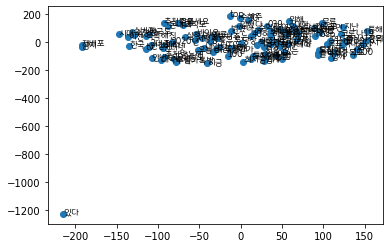

In [42]:
path = '/content/drive/My Drive/TTF/Binggrae.ttf'
fontprop = fm.FontProperties(fname=path, size=8)
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]),fontProperties =fontprop)

plt.draw()

##**Dacon 코드에 적용해보기**
### stemmer, lemmatizer 안함




In [44]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', 'null']

In [51]:
tokenizer_M = Mecab()
vec = HashingVectorizer(tokenizer=tokenizer_M, stop_words=stopwords, ngram_range=(1, 2))
# min_df : 최소 빈도수
# ngram_range : 단어의 묶음, ngram_range = (1, 2) : 단어의 묶음을 1개부터 2개까지 설정
#   'go home', 'very good'과 같은 2개 짜리 묶음도 인덱스를 받게 되는 것


In [53]:
X_cnt = vec.fit_transform(trn)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TypeError: ignored

In [ ]:
train = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_train.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv", index_col=0)
sample_submission = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv")

# train.head()
# test.head()
# sample_submission.head()

## **간단한 전처리 + 형태소 분석**

In [ ]:
tokenizer = Mecab()

In [ ]:
ttx = []
def text_preprocessing(text_list, tokenizer):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null']
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', 'null']

    token_list = []
    for text in tqdm.tqdm(text_list):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        ttx.append(txt)
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords ]
        token_list.append(token)

    return token_list

# train['token'], mecab = text_preprocessing(train['content'])

In [ ]:
# train['token'], mecab = text_preprocessing(train['content'])
# train['token'], mecab = text_preprocessing(train10000) 
# test['token'], mecab = text_preprocessing(testAll) 

trn_tokenlist = text_preprocessing(train['content'], tokenizer) 
tst_tokenlist = text_preprocessing(test['content'], tokenizer) 

NameError: ignored

In [ ]:
print(trn_tokenlist[:10])
print(ttx[:10])
# ttx.head()

[['데일리', 'marketpoint', '현재', '코스닥', '기관', '억', '순매도'], ['실적', '기반', '저가', '매집', '해야', '할', '월', '급등', '유망주', 'top', '전격', '공개'], ['하이스', '탁론', '선취', '수수료', '없', '월', '최저', '금리', '상품', '출시'], ['종합', '경제', '정보', '미디어', '데', '일리', '무단', '전재', '재', '배포', '금지'], ['전국', '적', '인', '소비', '붐', '조성', '기여', '할', '예정'], ['데일리', '권오석', '기자', '중소', '벤처', '기업', '부', '이하', '중기', '부', '대한민국', '동행', '세일', '개', 'tv', '홈', '쇼핑', '사', '홍보', '판매', '동참', '한다고', '일', '밝혔', '다'], ['대한민국', '동행', '세일', '라이브', '커머스', '언', '택트', '콘서트', 'o', 'o', '행사', '연계', '등', '비', '대면', '라는', '새로운', '형태', '소비', '촉진', '행사', '다'], ['개', '권역', '에서', '현장', '행사', '온', '오프라인', '판촉', 'tv', '홈', '쇼핑', '등', '연계', '행사', '통해', '소비', '심리', '진작', '하', '기', '위함', '다'], ['이번', '동행', '세일', '에서', '롯데', '공영', 'cj', '현대', 'gs', 'ns', '홈', '앤', '쇼핑', '등', '개', 'tv', '홈', '쇼핑', '사', '동행', '세일', '홍보', '방송', '판매', '동참', '해', '전국', '적', '인', '소비', '붐', '조성', '기여', '한다'], ['동행', '세일', '기간', '중', '홈', '쇼핑', '사', '에서', '판매', '방송', '사이', '영상', '을', '노출',

In [ ]:
def sub_special(s):
  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',s)

sub_special(train['content'])

TypeError: ignored

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(ttx)
# train['content'] 에 대해서 tf-idf 수행
print(tfidf_matrix.shape)
#(데이터 갯수, 유니크 단어들 갯수)

NameError: ignored

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

## **vectorization**

In [ ]:
def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer(num_words = 20000)     # 빈도 높은 20000 단어
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len)

    return X_train, vocab_size, tokenizer


In [ ]:
X_train, train_vocab_size, vectorizer = text2sequence(trn_tokenlist, max_len = 100)
Y_train = train['info']
print(X_train.shape, Y_train.shape)

X_test, test_vocab_size, vectorizer = text2sequence(tst_tokenlist, max_len = 100)
Y_test = sample_submission['info']
print(X_test.shape, Y_test.shape)

vocab_size :  37221
(118745, 100) (118745,)
vocab_size :  43015
(142565, 100) (142565,)


## **Embedding**

In [ ]:
# from gensim.models import Word2Vec

# train_embedding = Word2Vec(train_token_list, size=100, window=2, min_count=50, workers=4, iter=100, sg=1)
# test_embedding = Word2Vec(test_token_list, size=100, window=2, min_count=50, workers=4, iter=100, sg=1)
# model = gensim.models.load_word2vec_format('kor')
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/AI 진짜 뉴스/GoogleNews-vectors-negative300.bin.gz', binary = True)
embedding_matrix = np.zeros((trn_vocab_size, 300))



In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = trn_tokenlist, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
model.wv.vectors.shape

(16617, 100)

In [ ]:
print(model.wv.most_similar("행복"))

[('여러분', 0.7361487150192261), ('따뜻', 0.7256470918655396), ('배려', 0.7005615234375), ('꽃', 0.6993857026100159), ('마음', 0.6973257064819336), ('응원', 0.6833761930465698), ('독서', 0.6833001375198364), ('열매', 0.6820831298828125), ('서로', 0.677183985710144), ('데이트', 0.6744831204414368)]


In [ ]:
# 단어 리스트 작성
vocab = model.wv.index2word
# 전체 단어벡터 추출
wordvectors = []
for v in vocab:
	wordvectors.append(model.wv[v])

In [ ]:
print(wordvectors[:10])
# print(wordvectors.shape)
print(len(wordvectors))

[array([-6.2226146e-01, -6.4549273e-01,  7.3162752e-01,  1.7355635e+00,
       -1.3125702e+00, -4.7225213e-01,  1.3939051e-01, -1.2505916e-01,
        2.1195595e+00,  9.7785918e-03, -1.6473711e-01,  6.1325842e-01,
        9.5659190e-01,  5.4674268e-01, -4.3493479e-01,  2.8915300e+00,
        6.1408136e-02,  1.2420906e+00, -6.6361892e-01, -6.8999511e-01,
       -1.2255579e+00,  7.7850246e-01,  2.1892956e-01,  1.6760668e+00,
        1.0391451e-01,  2.4045780e-01,  4.9795729e-01,  8.3061874e-01,
       -3.5183346e-01,  1.3476028e-01,  2.7760410e-01,  4.3605343e-01,
       -1.2615632e-01,  1.2513243e+00,  9.1882360e-01,  9.5409822e-01,
       -3.7379627e+00,  1.6552440e+00, -1.5553714e+00,  1.8451918e+00,
       -2.5587921e+00,  6.6429788e-01, -3.1774261e+00,  1.3436751e+00,
       -1.6561176e+00,  4.7748974e-01,  1.6358064e-02, -2.3867892e-01,
        1.7935661e+00, -3.4354692e+00, -1.0977323e+00, -1.2341647e+00,
       -1.6555253e+00,  2.7872140e-03,  2.0687327e+00,  1.5344018e-01,
     

In [ ]:
X_trn = np.array(trn_tokenlist)
X_tst = np.array(tst_tokenlist)
Y_train_v = train['info'].values
Y_test_v = sample_submission['id'].values

In [ ]:
for index, word in enumerate(trn_tokenlist):
    if word in word2vec:
        embedding_vector = word2vec[word] 
        embedding_mxtrix[i] = embedding_vector 
    else:
        print("word2vec에 없는 단어입니다.")
        break

TypeError: ignored

In [ ]:
# def get_1d_cnn(vocab_size, max_len=1000):
#     model = Sequential()
#     model.add(Embedding(vocab_size, 300,weights = [embedding_matrx], input_length = max_len)) #임베딩 가중치 적용 코드
#     model.add(SpatialDropout1D(0.3))
#     model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
#     model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#     model.add(Dropout1D(0.3))
#     model.add(Dense(2, activation='sigmoid'))
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
#     model.summary()
#     return model
def get_model():
  
    model = Sequential([
        Embedding(train_vocab_size, 64, input_length=100),
        Dropout(.5),
        Conv1D(64, 7, padding="valid", activation="relu", strides=3),
        Conv1D(64, 7, padding="valid", activation="relu", strides=3),    
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(.3), 
        Dense(2, activation='sigmoid')
    ])
    
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model


def get_lstm():
  model = Sequential([
                      Embedding(train_vocab_size, 64, input_length=100),
                      Bidirectional(LSTM(64, return_sequences=True)),
                      Bidirectional(LSTM(64)),
                      Dense(2, activation='sigmoid')
  ])
  
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.01))   # 모델링
  return model

In [ ]:
n_fold = 5
n_class = 2
seed = 42
vocab_size = 20000
embedding_dim = 128
max_length = 64
padding_type='post'

In [ ]:
Y_train.shape

(118745,)

In [ ]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

In [ ]:
p = np.zeros((X_train.shape[0], n_class))
p_tst = np.zeros((X_test.shape[0], n_class))
for i_cv, (i_trn, i_val) in enumerate(cv.split(X_train, X_test), 1):
    clf = LogisticRegression()
    clf.fit(X_train[i_trn], X_test[i_trn])
    p[i_val, :] = clf.predict_proba(X_train[i_val])
    p_tst += clf.predict_proba(X_test) / n_class

ValueError: ignored

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

p = np.zeros((X_train.shape[0], 2))
p_val = np.zeros((X_train.shape[0], 2))
p_tst = np.zeros((X_test.shape[0], 2))
print(p_val.shape, p_tst.shape)

for i, (i_trn, i_val) in enumerate(cv.split(X_train, Y_train), 1):
    # print("i_trn : ", i_trn)
    # print("i_val : ", i_val)
    # print(f'training model for CV #{i}')
    # es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
    #                    verbose=1, mode='min', baseline=None, restore_best_weights=True)


    clf = LogisticRegression()
    # clf = get_model()
    # clf = get_lstm()   
    
    clf.fit(X_train[i_trn], Y_train[i_trn]) 
    # clf.fit(X_train[i_trn],
    #       to_categorical(Y_train[i_trn]),
    #       validation_data=(X_train[i_val], to_categorical(Y_train[i_val])),
    #       epochs=10,
    #       batch_size=512,
    #       callbacks=[es])
    
    p[i_val, :] = clf.predict_proba(X_train[i_val])
    # p[i_val, :] = clf.predict(X_train[i_val])
    p_tst += clf.predict_proba(X_test) / 2


(118745, 2) (142565, 2)


In [ ]:
print(f'Accuracy (CV): {accuracy_score(Y_train, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Accuracy (CV): {log_loss(pd.get_dummies(Y_train), p_val):8.4f}')

Accuracy (CV):  60.4767%
Accuracy (CV):   0.6931


In [ ]:
print(f'Accuracy (CV): {accuracy_score(Y_test, np.argmax(p_tst, axis=1)) * 100:8.4f}%')
# print(f'Accuracy (CV): {log_loss(pd.get_dummies(Y_test), p_tst):8.4f}')

Accuracy (CV):   6.9337%


In [ ]:
print(p_tst[:20])

[[2.18571924e+00 3.14280761e-01]
 [2.48870010e+00 1.12998967e-02]
 [2.10133032e+00 3.98669683e-01]
 [2.16480396e+00 3.35196045e-01]
 [2.46624193e+00 3.37580722e-02]
 [2.48131915e+00 1.86808538e-02]
 [1.67855642e+00 8.21443580e-01]
 [2.35384037e+00 1.46159629e-01]
 [2.49993626e+00 6.37362775e-05]
 [2.47011458e+00 2.98854199e-02]
 [2.11920883e+00 3.80791172e-01]
 [2.49971420e+00 2.85797402e-04]
 [2.49260711e+00 7.39289011e-03]
 [2.49989199e+00 1.08005872e-04]
 [2.49916193e+00 8.38070614e-04]
 [1.74416402e+00 7.55835982e-01]
 [2.37306052e+00 1.26939476e-01]
 [2.29694660e+00 2.03053404e-01]
 [2.49596367e+00 4.03632917e-03]
 [2.49941217e+00 5.87825889e-04]]


In [ ]:
print(clf.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 64, 128)           2560000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 20, 128)           114816    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 128)            114816    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

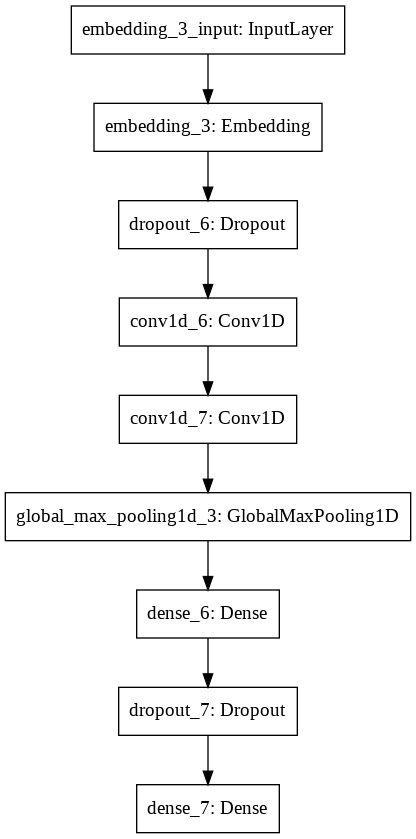

In [ ]:
plot_model(clf)

In [ ]:
# sample_submission['info'] = np.where(pred_test> 0.5, 1,0)
sample_submission['info'] = np.where(p_tst[:, 0] > 0.5, 0, 1)

sample_submission

,id,info
0,NEWS00237_1,1
1,NEWS00237_2,1
2,NEWS00237_3,1
3,NEWS00237_4,1
4,NEWS00237_5,1
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [ ]:
y = train['info'].values
y_test = sample_submission['id'].values

In [ ]:
X_train[:3]
X_test[:3]

array([list(['마이크로', '장비', '양산', '돌입', '전방', '업체', '투자', '확대', '로', '본업', '도', '호조', '연일', '신고']),
       list(['이데일리', '김대웅', '기자', '반도체', '장비', '업체', '코세', '스', '의', '기술', '력', '마이크로', '발광다이오드', '시대', '앞두고', '주목', '받고', '있습니다']),
       list(['최근', '대형', '업체', '들', '과', '거래', '맺고', '관련', '장비', '들', '의', '양산', '에', '돌입', '하면서', '주가', '도', '연일', '신', '고가', '달리', '고', '있습니다'])],
      dtype=object)

In [ ]:
y[:3]

array([0, 1, 1])

In [ ]:
feature_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/feature')
val_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/val')
tst_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/tst')
sub_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/sub')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

In [ ]:
algo_name = 'cnn'
feature_name = 'emb'
PATH = '/content/drive/My Drive/AI 진짜 뉴스/result'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [ ]:
n_fold = 5
n_class = 2
seed = 42
vocab_size = 20000
embedding_dim = 128
max_length = 64
padding_type='post'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

{'에': 1, '의': 2, '한': 3, '으로': 4, '로': 5, '했다': 6, '년': 7, '일': 8, '대': 9, '등': 10, '수': 11, '에서': 12, '종목': 13, '적': 14, '과': 15, '것': 16, '할': 17, '도': 18, '인': 19, '들': 20, '한국': 21, '주': 22, '이다': 23, '다': 24, '하는': 25, '있다': 26, '와': 27, '가능': 28, '코로나': 29, '하고': 30, '월': 31, '해': 32, '공개': 33, '전': 34, '이상': 35, '추천': 36, '목표': 37, '투자': 38, '명': 39, '만': 40, '원': 41, '된다': 42, '상한': 43, '주식': 44, '무료': 45, '거래': 46, '재': 47, '까지': 48, '된': 49, '정부': 50, '고': 51, '바이오': 52, '있는': 53, '및': 54, '이용': 55, '금리': 56, '관련': 57, '테마': 58, '최저': 59, '부터': 60, '방': 61, '분': 62, '실적': 63, '평가': 64, '함께': 65, '기자': 66, '시': 67, '수익': 68, '안': 69, '탁론': 70, '경제': 71, '배': 72, '업계': 73, '저': 74, '기업': 75, '위': 76, '자': 77, '신용': 78, '카톡': 79, '억원': 80, '말': 81, '효과': 82, '중': 83, '급등': 84, '환': 85, '오늘': 86, '한다': 87, '위해': 88, '미수': 89, '혜주': 90, '정책': 91, '당장': 92, '줄': 93, '사업': 94, '지금': 95, '대장': 96, '밝혔다': 97, '하여': 98, '급': 99, '소비자': 100, '매집': 101, '만원': 102, '스': 103, '성': 104, '돈'

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(train_sequences[:3])
print(test_sequences[:3])

[[302, 177, 685, 229, 113, 212, 488], [63, 300, 532, 1, 101, 215, 17, 31, 84, 414, 22, 563, 33], [230, 579, 70, 570, 226, 297, 31, 59, 56, 267, 305]]
[[3705, 714, 2304, 3151, 5989, 289, 38, 234, 5, 2880, 18, 3195, 2650, 868], [302, 66, 811, 714, 289, 103, 2, 216, 653, 3705, 108, 1611, 562, 749, 666], [163, 975, 289, 20, 15, 46, 4114, 57, 714, 20, 2, 2304, 1, 3151, 375, 194, 18, 2650, 265, 1408, 1634, 51, 666]]


In [ ]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(118745, 64) (142565, 64)


In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(.5),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),
        Conv1D(128, 7, padding="valid", activation="relu", strides=3),    
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(.3), 
        Dense(n_class, activation='softmax')
    ])
    
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
# print(p_val.shape, p_tst.shape)

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    # print("i_trn : ", i_trn)
    # print("i_val : ", i_val)
    print(y)
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)


    clf = get_model()    
    clf.fit(trn[i_trn],
          to_categorical(y[i_trn]),
          validation_data=(trn[i_val], to_categorical(y[i_val])),
          epochs=10,
          batch_size=512,
          callbacks=[es])
    

    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold


[0 1 1 ... 1 1 1]
training model for CV #1
Epoch 1/10
186/186 [==============================] - 8s 41ms/step - loss: 0.1230 - val_loss: 0.0513
Epoch 2/10
186/186 [==============================] - 7s 38ms/step - loss: 0.0254 - val_loss: 0.0528
Epoch 3/10
186/186 [==============================] - 7s 36ms/step - loss: 0.0083 - val_loss: 0.0669
Epoch 4/10
186/186 [==============================] - 7s 36ms/step - loss: 0.0064 - val_loss: 0.0883
Epoch 00004: early stopping
[0 1 1 ... 1 1 1]
training model for CV #2
Epoch 1/10
186/186 [==============================] - 7s 37ms/step - loss: 0.1395 - val_loss: 0.0570
Epoch 2/10
186/186 [==============================] - 7s 37ms/step - loss: 0.0243 - val_loss: 0.0511
Epoch 3/10
186/186 [==============================] - 7s 36ms/step - loss: 0.0102 - val_loss: 0.0817
Epoch 4/10
186/186 [==============================] - 7s 37ms/step - loss: 0.0067 - val_loss: 0.0846
Epoch 5/10
186/186 [==============================] - 7s 36ms/step - loss: 0.0

In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Accuracy (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  98.1835%
Accuracy (CV):   0.0509


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
print(clf.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 64, 128)           2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 20, 128)           114816    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 128)            114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

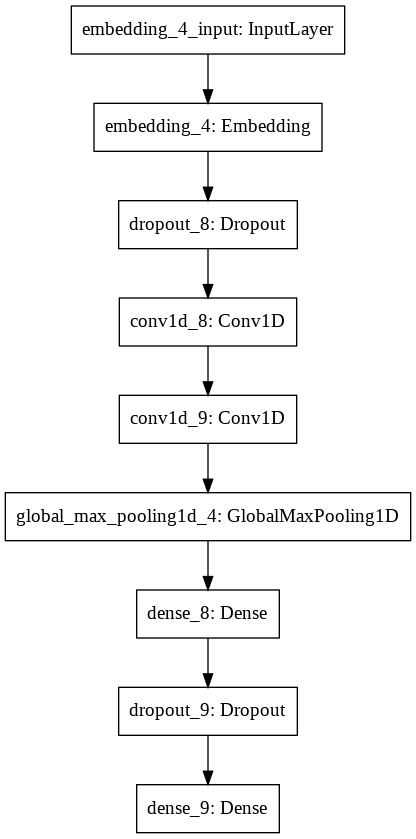

In [ ]:
plot_model(clf)

In [ ]:
test = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/news_test.csv")
sample_submission = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv")
# sub_file = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sub.csv")

X = train['content'][:10000].values
Y =  train['info'].values

print(pred_test.shape, sample_submission.shape)
pred_test = clf.predict(tst)
print(pred_test.shape, sample_submission.shape)
print(sample_submission['info'] )

# sample_submission.loc[:,'info'] = np.where(pred_test> 0.5, 1,0).reshape(-1)
sample_submission['info'] = np.where(pred_test> 0.5, 1,0)

sample_submission

(142565, 2) (142565, 2)
(142565, 2) (142565, 2)
0         0
1         0
2         0
3         0
4         0
         ..
142560    0
142561    0
142562    0
142563    0
142564    0
Name: info, Length: 142565, dtype: int64


,id,info
0,NEWS00237_1,1
1,NEWS00237_2,1
2,NEWS00237_3,1
3,NEWS00237_4,1
4,NEWS00237_5,1
...,...,...
142560,NEWS09482_72,0
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [ ]:
from pathlib import Path
import os

# sub = pd.read_csv(sample_file, index_col=0)
# print(sub.shape)
# sub.head()
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

sub = pd.read_csv("/content/drive/My Drive/AI 진짜 뉴스/dataset/sample_submission.csv", index_col=0)
# sub = sub[:10000]
# print(sub.shape)
print(sub.head())

sub_dir = Path('/content/drive/My Drive/AI 진짜 뉴스/result')
sub_file = sub_dir / f'{model_name}.csv'

             info
id               
NEWS00237_1     0
NEWS00237_2     0
NEWS00237_3     0
NEWS00237_4     0
NEWS00237_5     0


In [ ]:
sample_submission.loc[:,["id","info"]].to_csv(sub_file, index = False)
sample_submission

,id,info
0,NEWS00237_1,1
1,NEWS00237_2,1
2,NEWS00237_3,1
3,NEWS00237_4,1
4,NEWS00237_5,1
...,...,...
142560,NEWS09482_72,0
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [ ]:


sub[sub.columns] = p_tst
sub.head()
print(p_tst.shape)


NameError: ignored

In [ ]:
sub.to_csv(sub_file)